# $\fbox{4-1}$ セミパラメトリック分析 ~ 点推定

## ハザードと発生率の関係

## セミパラメトリックモデル

## Cox 比例ハザードモデル


### Cox 比例ハザードモデルの数理的特性


## セミパラメトリックモデルのレセプトへの適用

### ベースライン発生率の意味


## 最尤推定法

### 例 

### 尤度関数


In [1]:
%matplotlib notebook

import gc
import math
import pickle

# 本書 3 章の関数群を含む自作ライブラリ
import mylibs.mylib3 as mylib3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

pd.options.display.max_rows = 6
pd.options.display.max_columns = 12

In [2]:
# 尤度関数
def L(p):
    k = math.factorial(10) / (math.factorial(3) * math.factorial(7))
    return k * p**3 * (1-p)**7

<IPython.core.display.Javascript object>


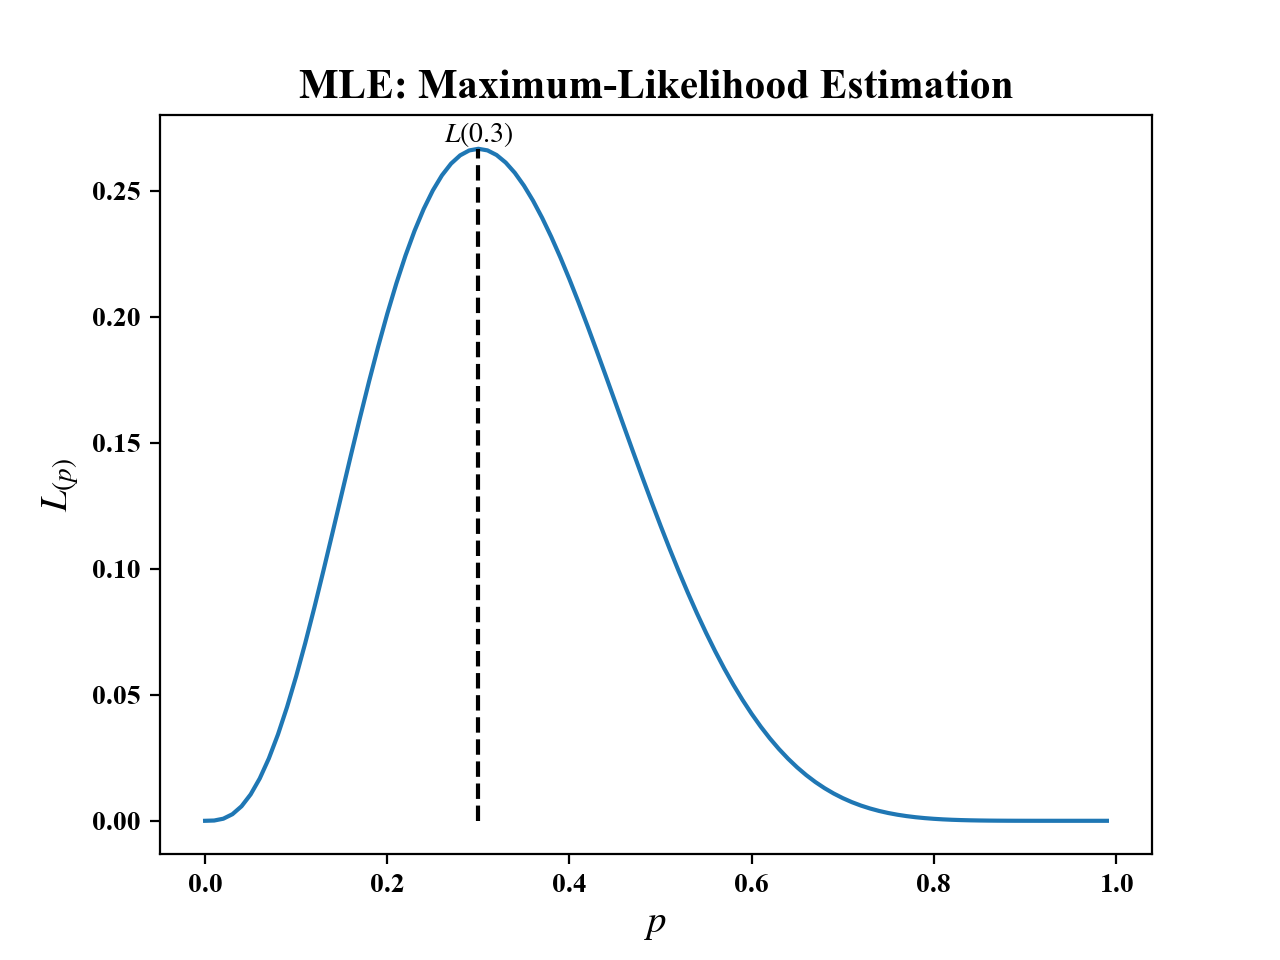

Text(0.5, 1.0, 'MLE: Maximum-Likelihood Estimation')

In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 尤度関数 L(p) の描画
fig = plt.figure()
ax = fig.add_subplot(111)
p = np.arange(100) / 100
ax.plot(p, L(p))
ax.plot([0.3, 0.3], [0, L(0.3)], '--', c='k')
ax.text(0.3, L(0.3), '$L(0.3)$', ha='center', va='bottom')
ax.set_xlabel(r'$p$', fontsize=14)
ax.set_ylabel(r'$L_{(p)}$', fontsize=14)
ax.set_title('MLE: Maximum-Likelihood Estimation', fontsize=15)

## 最尤推定法による重みベクトルの点推定

### 尤度関数の定義（$1$ 件のイベント発生）

### 尤度関数の定義（複数のイベント発生）


### Breslow 部分尤度


### Efron 部分尤度


## ベースライン発生率の推定方法



## モデルの決定


### Breslow 部分尤度の対数尤度関数


## データ分析

### 男女別・年齢別・血圧別エクスポージャテーブルとアウトカムテーブルの作成

In [4]:
# 分析開始時点 (2010年1月)
start_study_t = 2010
# 分析終了時点 (2019年12月)
end_study_t = 2019.999

df_hc = pd.read_csv('./pseudo_medical/records/incl_bp/healthckeckup.csv')
df_info = pd.read_csv('./pseudo_medical/records/incl_bp/info.csv')
df_commons = pd.read_csv('./pseudo_medical/records/incl_bp/commons.csv')

In [5]:
# df_info, df_commons を健診レコードを持つ者のみに絞り込む
df_hc, df_info, df_commons = mylib3.filter_iid_with_hc(
    df_hc, df_info, df_commons)

# ALB table, Exposure table を作成
npa_obs_ym, df_alb_table, df_exposure_table = \
    mylib3.create_obs_ym_and_alb_table_and_exposure_table(
        start_study_t, end_study_t, df_info)

# Outcome (event) table の作成
df_outcome_table = mylib3.create_admission_table(
    npa_obs_ym, df_alb_table, df_commons)

# DBP table, SBP table の作成
df_dbp_table = mylib3.create_bp_tables(npa_obs_ym, df_alb_table, df_hc, 'dbp')
df_sbp_table = mylib3.create_bp_tables(npa_obs_ym, df_alb_table, df_hc, 'sbp')

# 各 table の shape が一致していることを確認
print(df_alb_table.shape, '\n',
      df_exposure_table.shape, '\n',
      df_outcome_table.shape, '\n',
      df_dbp_table.shape, '\n',
      df_sbp_table.shape)

(2241, 131) 
 (2241, 131) 
 (2241, 131) 
 (2241, 131) 
 (2241, 131)


In [6]:
dict_tables = {'alb': {}, 'exposure': {}, 'outcome': {}, 'dbp': {}, 'sbp': {}}

dict_tables['alb']['both'] = df_alb_table
dict_tables['exposure']['both'] = df_exposure_table
dict_tables['outcome']['both'] = df_outcome_table
dict_tables['dbp']['both'] = df_dbp_table
dict_tables['sbp']['both'] = df_sbp_table

for key in dict_tables.keys():
    for sex in ['M', 'F']:
        is_sex = (dict_tables[key]['both'].sex==sex)
        dict_tables[key][sex] = dict_tables[key]['both'].loc[is_sex, :]

In [7]:
dbp = dict_tables['dbp']['both'][npa_obs_ym].values
sbp = dict_tables['sbp']['both'][npa_obs_ym].values

dbp

array([[nan, nan, nan, ..., 70., 70., 70.],
       [nan, nan, nan, ..., 70., 70., 70.],
       [nan, nan, nan, ..., 76., 76., 76.],
       ...,
       [nan, nan, nan, ..., 75., 75., 75.],
       [nan, nan, nan, ..., 72., 72., 72.],
       [nan, nan, nan, ..., 73., 73., 73.]])

In [8]:
dbp, sbp = 95, 150  # I度高血圧 → 3
mylib3.calc_bp_class(dbp, sbp)

3

In [9]:
mylib3.calc_bp_class(np.nan, np.nan)

0

In [10]:
def calc_bp_class_allowing_nan(dbp, sbp):
    if np.isnan(dbp) | np.isnan(sbp):
        return None
    else:
        return mylib3.calc_bp_class(dbp, sbp)

In [11]:
ufunc_calc_bp_class = np.frompyfunc(calc_bp_class_allowing_nan, 2, 1)

print(dbp, sbp, ufunc_calc_bp_class(dbp, sbp))
print(np.nan, np.nan, ufunc_calc_bp_class(np.nan, np.nan))

95 150 3
nan nan None


In [12]:
dbp = dict_tables['dbp']['both'][npa_obs_ym].values
sbp = dict_tables['sbp']['both'][npa_obs_ym].values
df_class = dict_tables['dbp']['both'].copy()
df_class[npa_obs_ym] = ufunc_calc_bp_class(dbp, sbp)
dict_tables['class'] = {}
dict_tables['class']['both'] = df_class

for sex in ['M', 'F']:
    is_sex = (dict_tables['class']['both'].sex == sex)
    dict_tables['class'][sex] = dict_tables['class']['both'].loc[is_sex, :]

### 計算の高速化

In [13]:
def make_filters(npa_obs_ym, dict_tables, sex, age):
    df_alb = dict_tables['alb'][sex]
    is_alb = (df_alb[npa_obs_ym] == age)
    df_exp = dict_tables['exposure'][sex]
    is_exp = (df_exp[npa_obs_ym] == 1)
    df_out = dict_tables['outcome'][sex]
    is_out = (df_out[npa_obs_ym] == 1)
    return is_alb, is_exp, is_out

In [14]:
def get_bp_array(npa_obs_ym, dict_tables, sex, age, exp_or_out, dbp_sbp_or_class):
    is_alb, is_exp, is_out = make_filters(npa_obs_ym, dict_tables, sex, age)
    df_bp = dict_tables[dbp_sbp_or_class][sex]
    if exp_or_out == 'exp':
        df = df_bp[npa_obs_ym][is_alb & is_exp].values
    elif exp_or_out == 'out':
        df = df_bp[npa_obs_ym][is_alb & is_out].values
    else:
        raise ValueError('exp_or_out must be "exp" or "out"!')
    N, T = df.shape
    df = df.reshape(N * T)
    return df[pd.notnull(df)]

In [15]:
sex, age = 'M', 60

dbp_exp = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'exp', 'dbp')
sbp_exp = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'exp', 'sbp')
class_exp = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'exp', 'class')
print('Shape of DBP for exposure: ', dbp_exp.shape)
print('Shape of SBP for exposure: ', sbp_exp.shape)
print('Shape of BP class for exposure: ', class_exp.shape)
print('DBP sample: ', dbp_exp)
print('SBP sample: ', sbp_exp)
print('BP class sample: ', class_exp)

print("\n")

dbp_out = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'out', 'dbp')
sbp_out = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'out', 'sbp')
class_out = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'out', 'class')
print('Shape of DBP for outcome: ', dbp_out.shape)
print('Shape of SBP for outcome: ', sbp_out.shape)
print('Shape of BP class for outcome: ', class_out.shape)
print('DBP outcome: ', dbp_out)
print('SBP outcome: ', sbp_out)
print('BP class outcome: ', class_out)

Shape of DBP for exposure:  (1265,)
Shape of SBP for exposure:  (1265,)
Shape of BP class for exposure:  (1265,)
DBP sample:  [ 81.  88.  88. ... 102. 102. 102.]
SBP sample:  [138. 140. 140. ... 165. 165. 165.]
BP class sample:  [2.0 3.0 3.0 ... 4.0 4.0 4.0]


Shape of DBP for outcome:  (23,)
Shape of SBP for outcome:  (23,)
Shape of BP class for outcome:  (23,)
DBP outcome:  [ 93.  93.  88.  97.  96.  84.  96.  92.  88.  88.  91. 101.  88.  85.
  85.  80.  84. 103.  94.  71. 101.  80.  84.]
SBP outcome:  [145. 145. 132. 152. 153. 132. 147. 160. 137. 131. 147. 166. 136. 128.
 131. 133. 135. 163. 140. 111. 172. 135. 127.]
BP class outcome:  [3.0 3.0 2.0 3.0 3.0 2.0 3.0 4.0 2.0 2.0 3.0 4.0 2.0 2.0 2.0 2.0 2.0 4.0
 3.0 0.0 4.0 2.0 1.0]


In [16]:
dict_bp = {'M': {}, 'F': {}}
dict_bp['M'] = {'exp': {'dbp': {}, 'sbp': {}, 'class': {}},
                'out': {'dbp': {}, 'sbp': {}, 'class': {}}}
dict_bp['F'] = {'exp': {'dbp': {}, 'sbp': {}, 'class': {}},
                'out': {'dbp': {}, 'sbp': {}, 'class': {}}}

for sex in ['M','F']:
    for age in np.arange(65):
        dbp_exp   = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'exp', 'dbp')
        sbp_exp   = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'exp', 'sbp')
        class_exp = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'exp', 'class')
        dbp_out   = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'out', 'dbp')
        sbp_out   = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'out', 'sbp')
        class_out = get_bp_array(npa_obs_ym, dict_tables, sex, age, 'out', 'class')
        dict_bp[sex]['exp']['dbp'][age]   = dbp_exp
        dict_bp[sex]['exp']['sbp'][age]   = sbp_exp
        dict_bp[sex]['exp']['class'][age] = class_exp
        dict_bp[sex]['out']['dbp'][age]   = dbp_out
        dict_bp[sex]['out']['sbp'][age]   = sbp_out
        dict_bp[sex]['out']['class'][age] = class_out

In [17]:
f = open('./pseudo_medical/processed/incl_bp/dict_bp.binaryfile', 'wb')  # wb: Write Binary
pickle.dump(dict_bp, f)
f.close()

In [18]:
f = open('./pseudo_medical/processed/incl_bp/dict_bp.binaryfile', 'rb')  # rb: Read Binary
dict_bp = pickle.load(f)
f.close()

dict_bp['M']['exp']['class'][60]

array([2.0, 3.0, 3.0, ..., 4.0, 4.0, 4.0], dtype=object)

In [19]:
def alpha(dict_bp, w, sex, x):
    out_classes = dict_bp[sex]['out']['class'][x].astype('f8')
    return w * out_classes.sum()


w, sex, x = 0.5, 'M', 60
alpha(dict_bp, w, sex, x)

29.0

In [20]:
def beta(dict_bp, w, sex, x):
    exp_classes = dict_bp[sex]['exp']['class'][x].astype('f8')
    return (np.exp(w * exp_classes)).sum()

w, sex, x = 0.5, 'M', 60
beta(dict_bp, w, sex, x)

4639.792912345683

In [21]:
def log_L_by_sex_age(dict_bp, w, sex, x, out_num):
    return alpha(dict_bp, w, sex, x) - out_num * np.log(beta(dict_bp, w, sex, x))


w, sex, x = 0.5, 'M', 60
out_num = len(dict_bp[sex]['out']['class'][x])
log_L_by_sex_age(dict_bp, w, sex, x, out_num)

-165.17577530507955

In [22]:
def neg_log_L(w, dict_bp):
    log_L = 0
    for sex in ['M', 'F']:
        for x in np.arange(65):
            out_num = len(dict_bp[sex]['out']['class'][x])
            if out_num > 0:
                log_L = log_L + log_L_by_sex_age(dict_bp, w, sex, x, out_num)
            else:
                pass
    return - log_L


w = 0.5
neg_log_L(w, dict_bp)

4764.576454258377

w_min = [0.3]
nll_min = 4749.974620955603


<IPython.core.display.Javascript object>


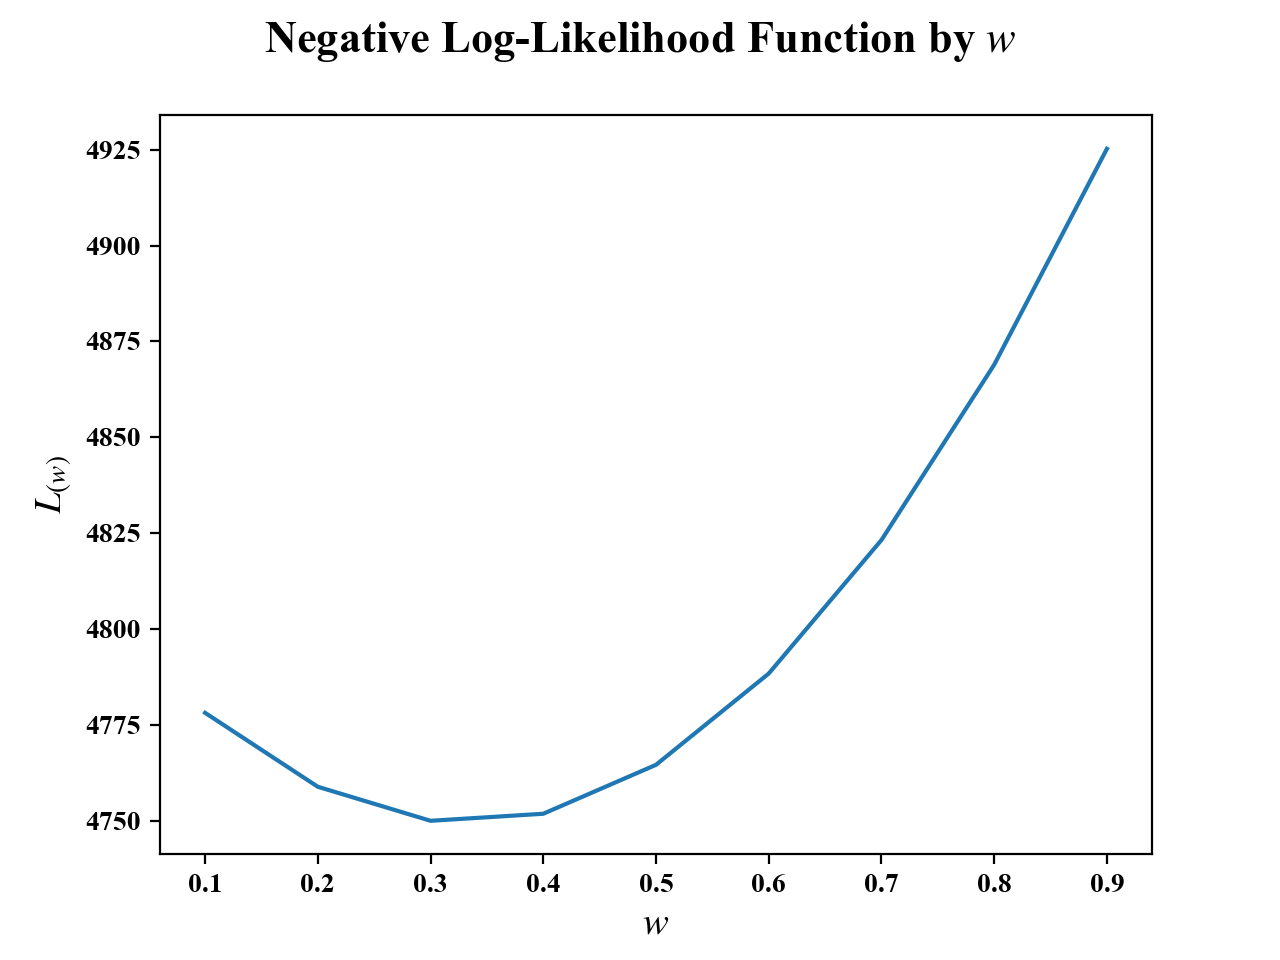

Text(0.5, 0.98, 'Negative Log-Likelihood Function by $w$')

In [23]:
W = (np.arange(9) + 1) / 10 # [0.1, 0.2 , ... , 0.9]
nll = [] # Negative Log Likelihood function
for w in W:
    nll.append(neg_log_L(w, dict_bp))

nll = np.array(nll)
nll_min = nll[nll == nll.min()][0]
w_min = W[nll == nll_min]
print('w_min =', w_min)
print('nll_min =', nll_min)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(W, nll) 
ax.set_xlabel(r'$w$', fontsize=14)
ax.set_ylabel(r'$L_{(w)}$', fontsize=14)
fig.suptitle(r'Negative Log-Likelihood Function by $w$', fontsize=16)

In [24]:
import scipy as sp

w = 0.3
opt_result = sp.optimize.minimize(neg_log_L,
                                  w,
                                  args=(dict_bp),
                                  method='Nelder-Mead')

opt_result

 final_simplex: (array([[0.33310547],
       [0.33304687]]), array([4749.38450432, 4749.38450571]))
           fun: 4749.384504319535
       message: 'Optimization terminated successfully.'
          nfev: 20
           nit: 10
        status: 0
       success: True
             x: array([0.33310547])

In [25]:
f = open('./pseudo_medical/processed/incl_bp/opt_result.binaryfile', 'wb')  # wb: Write Binary
pickle.dump(opt_result, f)
f.close()

In [26]:
f = open('./pseudo_medical/processed/incl_bp/opt_result.binaryfile', 'rb')  # rb: Read Binary
opt_result = pickle.load(f)
f.close()

opt_result.x

array([0.33310547])

## 真の発生率係数 $f$ の指数近似

<IPython.core.display.Javascript object>


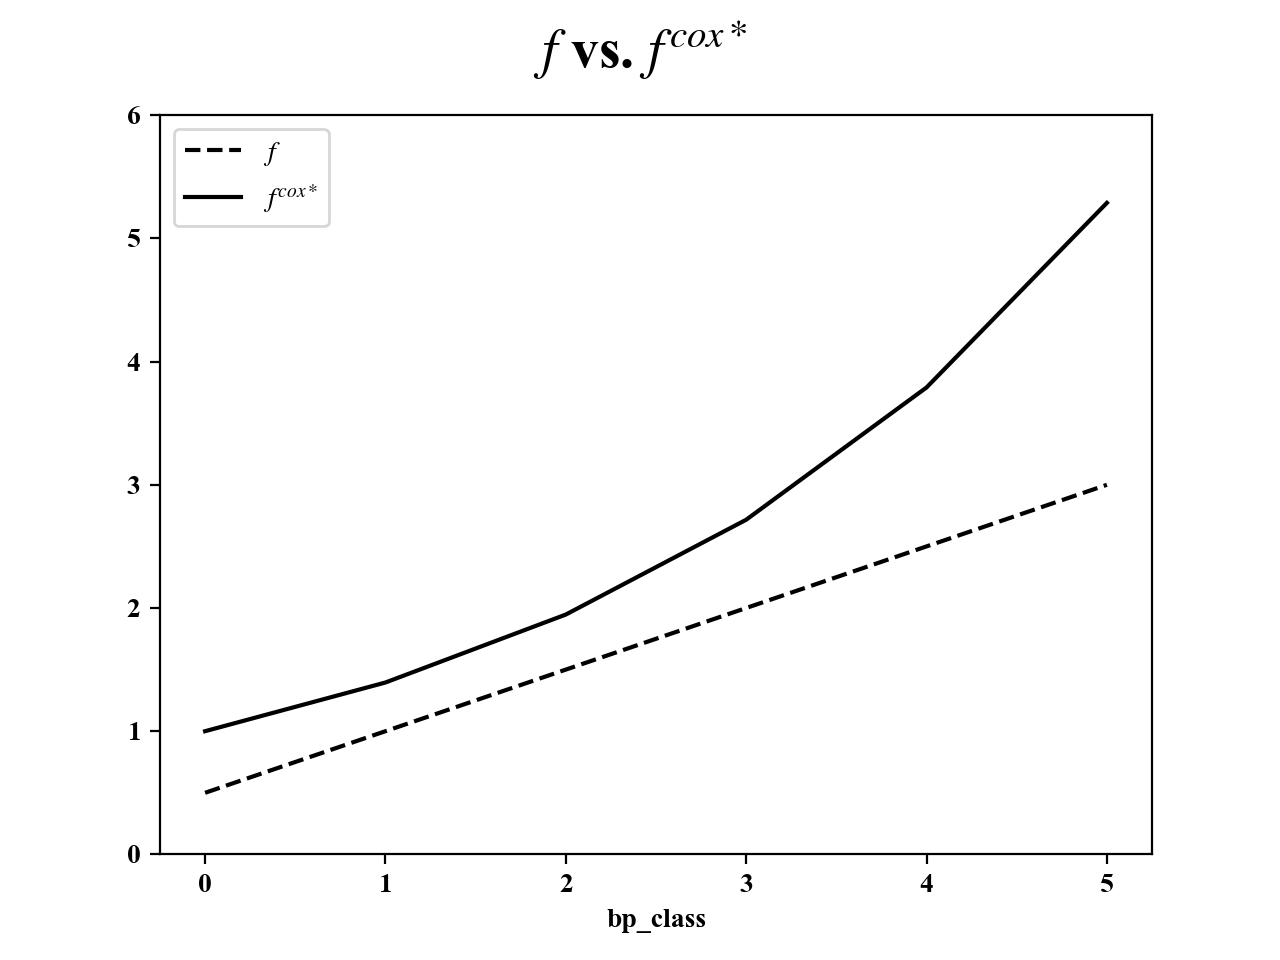

Text(0.5, 0.98, '$f$ vs. $f^{cox*}$')

In [27]:
w = opt_result.x[0]

x = np.arange(6)
f = 0.5 * x + 0.5
f_cox = np.exp(w * x)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, f, c='k', ls='--', label=r'$f$')
ax.plot(x, f_cox, c='k', label=r'$f^{cox*}$')
ax.set_ylim([0, 6])
ax.set_xlabel('bp_class')
ax.legend(loc='best')
fig.suptitle(r'$f$ vs. $f^{cox*}$', fontsize=20)

### ベースライン発生率の推定



In [28]:
def calc_bases(w, sex, x):
    _out = len(dict_bp[sex]['out']['class'][x])
    _exp = len(dict_bp[sex]['exp']['class'][x])
    _beta = beta(dict_bp, w, sex, x)
    _rate = _out / _exp
    _baseline = _out / _beta
    return (_out, _exp, _beta, _rate, _baseline)


w = opt_result.x[0]
(sex, x) = ('M', 60)
calc_bases(w, sex, x)

(23, 1265, 2876.9796256179907, 0.01818181818181818, 0.007994495266910163)

In [29]:
# ベースライン発生率の計算
def calc_summary(dict_bp, w):
    cols = ['sex', 'age', 'out', 'exp', 'beta', 'rate', 'baseline']
    df = pd.DataFrame(np.zeros((2*65, 7)), columns=cols)

    for sex in ['M','F']:
        for age in np.arange(65):
            i = (sex=='F') * 65 + age
            df.loc[i, 'sex'] = sex
            df.loc[i, 'age'] = age
            df.loc[i, cols[2:]] = calc_bases(w, sex, age)
    return df


w = opt_result.x[0]
df_summary = calc_summary(dict_bp, w)
df_summary.to_csv('./pseudo_medical/processed/incl_bp/df_summary.csv', index=False)

df_summary

,sex,age,out,exp,beta,rate,baseline
0,M,0.0,3.0,314.0,390.033267,0.009554,0.007692
1,M,1.0,1.0,677.0,860.863440,0.001477,0.001162
2,M,2.0,7.0,796.0,1011.510175,0.008794,0.006920
...,...,...,...,...,...,...,...
127,F,62.0,17.0,1448.0,2906.680608,0.011740,0.005849
128,F,63.0,21.0,1356.0,2839.252421,0.015487,0.007396
129,F,64.0,13.0,1243.0,2599.738200,0.010459,0.005001


<IPython.core.display.Javascript object>


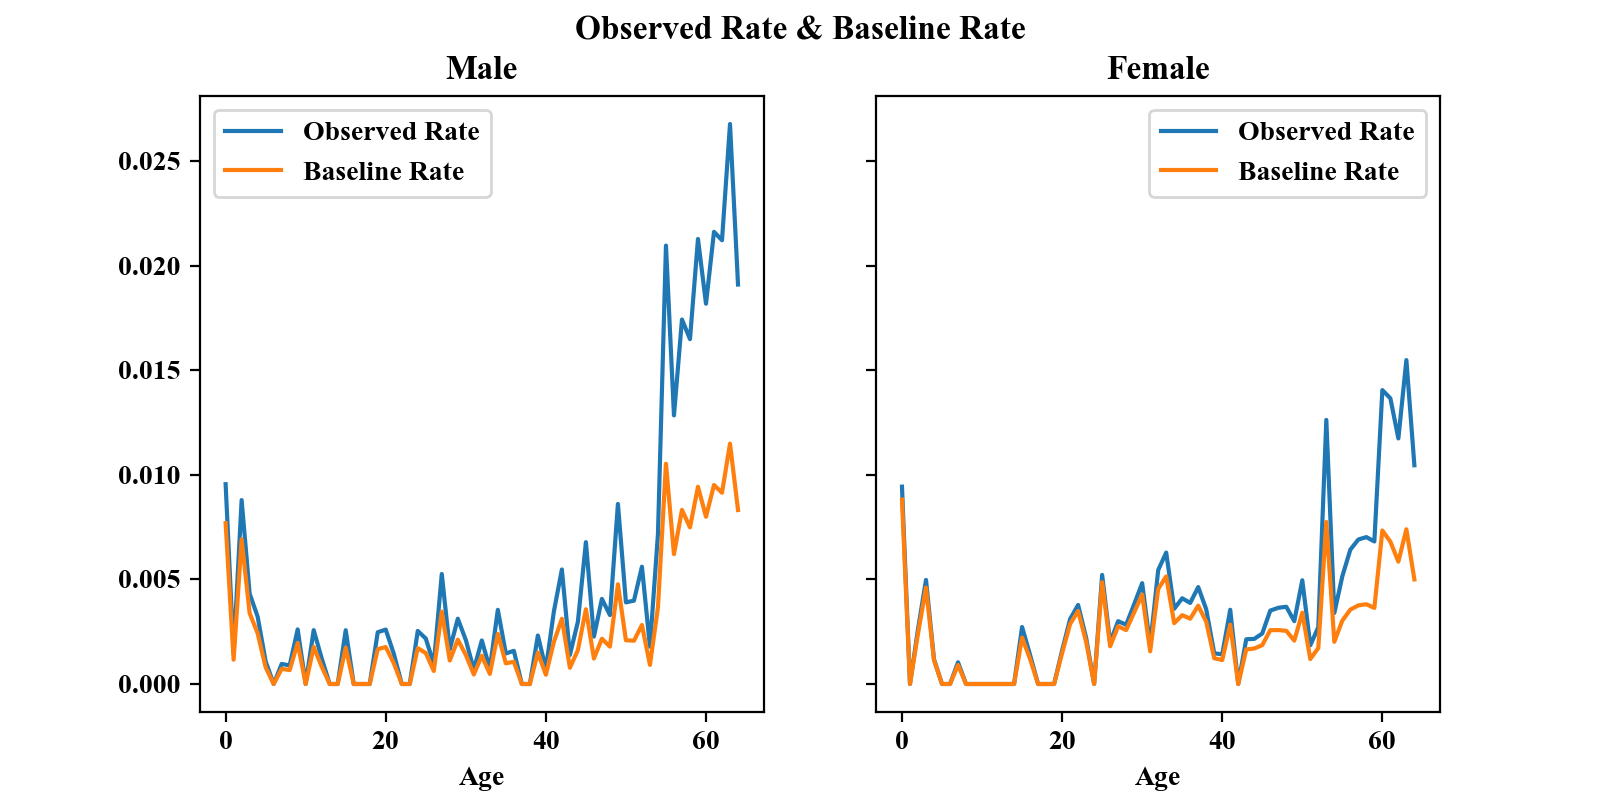

In [30]:
fig = plt.figure(figsize=(8, 4))
axes = fig.subplots(1, 2, sharex=True, sharey=True)
# 男性
_df = df_summary[df_summary['sex']=='M']
ax = axes[0]
ax.plot(_df.age, _df.rate, label='Observed Rate')
ax.plot(_df.age, _df.baseline, label='Baseline Rate')
ax.set_title('Male')
ax.set_xlabel('Age')
ax.legend(loc='best')
# 女性
_df = df_summary[df_summary['sex']=='F']
ax = axes[1]
ax.plot(_df.age, _df.rate, label='Observed Rate')
ax.plot(_df.age, _df.baseline, label='Baseline Rate')
ax.set_title('Female')
ax.set_xlabel('Age')
ax.legend(loc='best')
# 共通
fig.suptitle('Observed Rate & Baseline Rate')
fig.show()

In [31]:
f_ratio = (df_summary['baseline'] / df_summary['rate']).mean()

f_ratio

0.6823743338018003

<IPython.core.display.Javascript object>


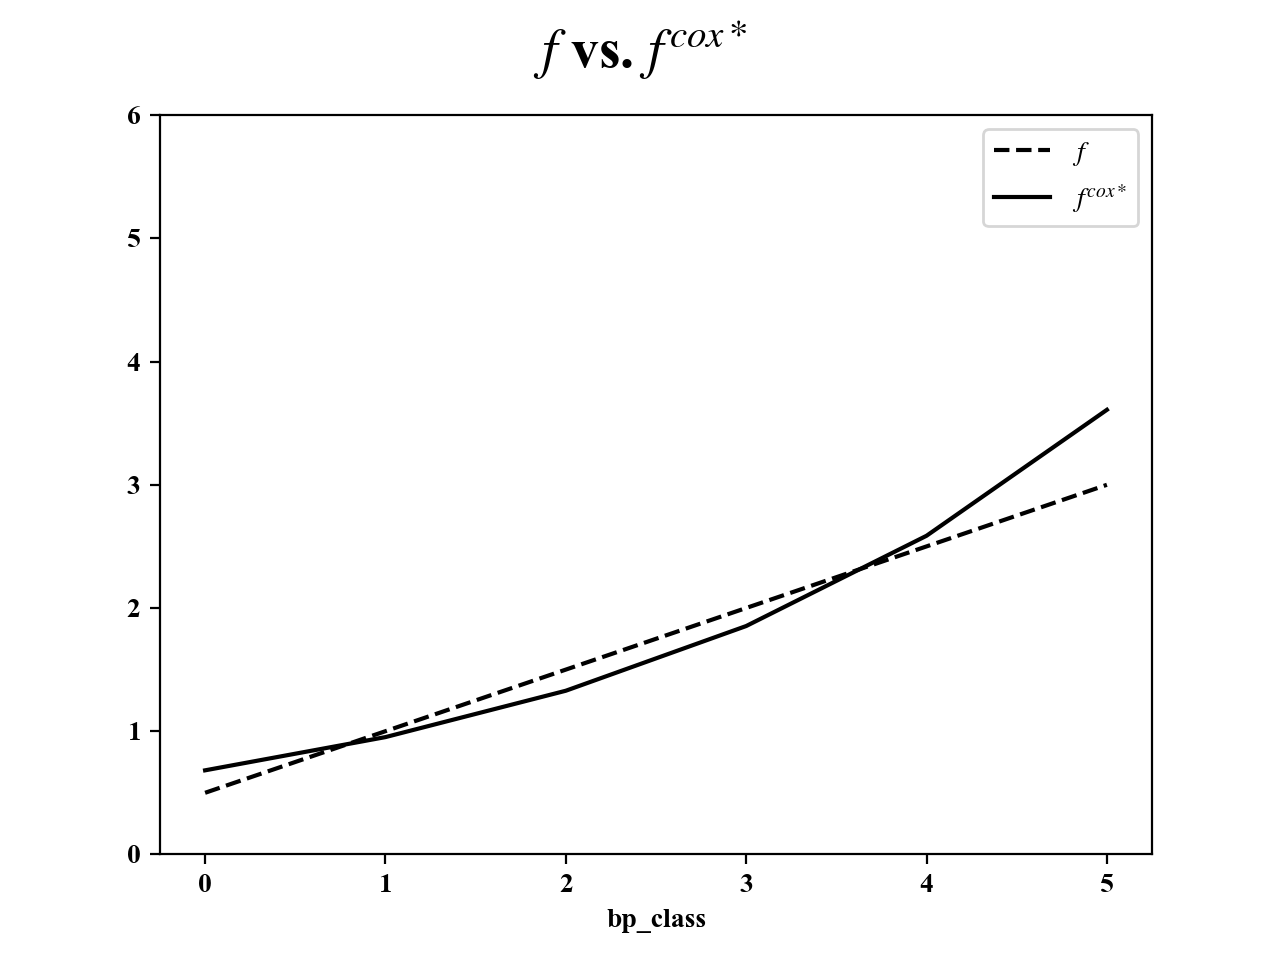

Text(0.5, 0.98, '$f$ vs. $f^{cox*}$')

In [32]:
w = opt_result.x[0]

x = np.arange(6)
f = 0.5 * x + 0.5
f_cox = np.exp(w * x)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, f, c='k', ls='--', label=r'$f$')
ax.plot(x, f_cox * f_ratio, c='k', label=r'$f^{cox*}$')
ax.set_ylim([0, 6])
ax.set_xlabel('bp_class')
ax.legend(loc='best')
fig.suptitle(r'$f$ vs. $f^{cox*}$', fontsize=20)

## まとめ